In [ ]:
import cv2
import numpy as np

class DayNightClassifier:
    def __init__(self,
                 night_intensity_ratio_threshold: float = 0.55,
                 brightness_threshold: int = 95):

        self.brightness_threshold = brightness_threshold
        self.night_intensity_ratio_threshold = night_intensity_ratio_threshold

    @staticmethod
    def enhance_contrast(image):
        clahe = cv2.createCLAHE(clipLimit=2.15, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
        return enhanced_image

    def calculate_histogram_and_brightness(self, image_path):
        # Đọc hình ảnh và chuyển sang grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            return None, None

        # Tăng cường độ tương phản
        image = self.enhance_contrast(image)

        # Tính toán histogram
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = hist / hist.sum()

        # Tính độ sáng trung bình
        avg_brightness = np.mean(image)

        # Tính tỷ lệ pixel tối
        dark_pixel_ratio = hist[:self.brightness_threshold].sum()

        return dark_pixel_ratio, avg_brightness

    def isDay(self, image_path):
        dark_pixel_ratio, avg_brightness = self.calculate_histogram_and_brightness(image_path)

        if dark_pixel_ratio is None or avg_brightness is None:
            return None

        # Phân loại dựa trên tỷ lệ pixel tối
        if dark_pixel_ratio > self.night_intensity_ratio_threshold:
            return False  # Đêm

        # Phân loại dựa trên độ sáng trung bình
        return avg_brightness > self.brightness_threshold  # Ngày nếu độ sáng cao hơn ngưỡng

100%|██████████| 11/11 [2:16:18<00:00, 743.53s/it]


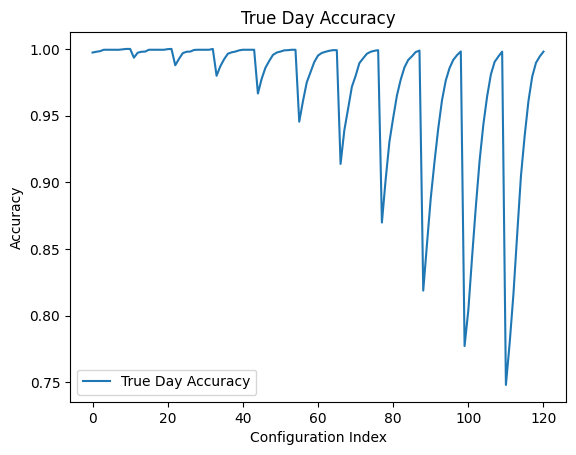

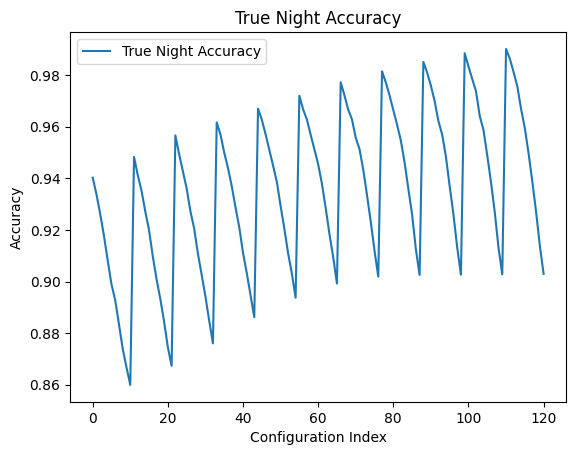

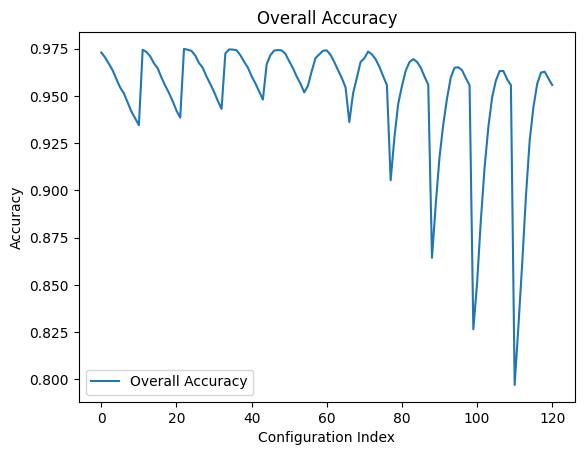

In [ ]:
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Thay đổi cặp giá trị
night_intensity_values = np.linspace(0.50, 0.60, num=11)
brightness_values = np.arange(90, 101)

# Danh sách các hình ảnh
imgs = glob.glob('../data/raw/train_20241023/**/*.jpg', recursive=True)

# Khởi tạo danh sách lưu trữ kết quả
accuracy_day = []
accuracy_night = []
overall_accuracy = []

# Lặp qua các cặp giá trị
for night_intensity in tqdm(night_intensity_values):
    for brightness in tqdm(brightness_values):
        classifier = DayNightClassifier(
            night_intensity_ratio_threshold=night_intensity,
            brightness_threshold=brightness
        )

        true_day = 0
        true_night = 0
        total_day = 0
        total_night = 0

        # Duyệt qua các ảnh
        for img in imgs:
            is_day = classifier.isDay(img)
            if is_day:
                if "day" in img:
                    true_day += 1
                total_day += 1
            else:
                if "night" in img:
                    true_night += 1
                total_night += 1

        # Tính toán độ chính xác
        day_accuracy = true_day / total_day if total_day > 0 else 0
        night_accuracy = true_night / total_night if total_night > 0 else 0
        total_accuracy = (
            (true_day + true_night) / (total_day + total_night)
            if (total_day + total_night) > 0
            else 0
        )

        # Lưu kết quả
        accuracy_day.append(day_accuracy)
        accuracy_night.append(night_accuracy)
        overall_accuracy.append(total_accuracy)

# Vẽ đồ thị
plt.figure()
plt.plot(range(len(accuracy_day)), accuracy_day, label='True Day Accuracy')
plt.xlabel('Configuration Index')
plt.ylabel('Accuracy')
plt.title('True Day Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(len(accuracy_night)), accuracy_night, label='True Night Accuracy')
plt.xlabel('Configuration Index')
plt.ylabel('Accuracy')
plt.title('True Night Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(len(overall_accuracy)), overall_accuracy, label='Overall Accuracy')
plt.xlabel('Configuration Index')
plt.ylabel('Accuracy')
plt.title('Overall Accuracy')
plt.legend()
plt.show()

In [15]:
max_ = np.max(overall_accuracy)
index = overall_accuracy.index(max_)
print(f'Maximum accuracy: {max_}')
print(f'Configuration index: {index}')
print(f'Night intensity ratio: {night_intensity_values[index//len(brightness_values)]}')
print(f'Brightness threshold: {brightness_values[index%len(brightness_values)]}')

accuracy_day[index], accuracy_night[index]

Maximum accuracy: 0.97491537192952
Configuration index: 22
Night intensity ratio: 0.52
Brightness threshold: 90


(0.9877382183483527, 0.9566498316498316)

In [ ]:
# [0.55, 0.95]
# True day accuracy: 0.9950450450450451
# True night accuracy: 0.9454844682164164
# Accuracy: 0.9741341897404739

# [0.54, 93]
# True day accuracy: 0.9909199166418577
# True night accuracy: 0.9510722465125963
# Accuracy: 0.9743077857824841